In [2]:
import numpy as np
from pandas import read_csv

# from average_atom.core.average_atom_new import AverageAtom as AA
from average_atom.core.aa_types import AverageAtomFactory
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['legend.fontsize'] = 8

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ModuleNotFoundError: No module named 'mendeleev'


In [5]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.7#699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

R  = 10*rs

Ti_eV = 1 
Te_eV = 1

#

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU


aa_ZJ  = AverageAtomFactory.create_model("ZJ_ISModel", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=False, xc_type='KSDT', Npoints=2000, rmin=1e-4, N_stencil_oneside = 2)
# aa_W  = AverageAtomFactory.create_model("ZJ_ISModel_W", Z, A, Ti_AU, Te_AU, rs, R,  Weizsacker_λ=1/5, name=name, ignore_vxc=False, xc_type='KSDT', Npoints=2000, rmin=1e-4, N_stencil_oneside = 2)
# aa_W.nf_init = 1/aa_W.grid.xs**1.5*np.exp(-2*aa_W.grid.xs)
# aa_W.nf_init *= Z/aa_W.grid.integrate_f(aa_W.nf_init )
# aa_W.ne = aa_W.nf_init + 0*aa_W.nb_init
# aa_ZJ_cs  = AverageAtomFactory.create_model("ZJ_CSModel", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=False, Npoints=2000, rmin=1e-4, N_stencil_oneside = 2)
# aa_CS  = AverageAtomFactory.create_model("TFStarret2014", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=False, Npoints=2000, rmin=1e-4, N_stencil_oneside = 2)

________________________
Generating NPA
T:  0.03674932539796232
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized


In [3]:
%%time
aa_ZJ.solve(verbose=True, picard_alpha=0.5)
aa_ZJ.set_uii_eff()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = -6.844847875e-01, change: 2.822080212e+00 (converged=False)
	φe Err =  5.605e-11, φe change =  7.588e-01
	ne Err =  8.630e-02, ne change =  8.272e-04
	Q =  0.000e+00 -> -4.774e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=True)
	Change =  2.092e+00
__________________________________________
TF Iteration 1
	μ = -6.844847875e-01, change: 0.000000000e+00 (converged=True)
	φe Err =  6.256e-11, φe change =  7.971e-02
	ne Err =  1.130e-01, ne change =  3.748e-04
	Q = -4.774e+00 ->  6.441e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=True)
	Change =  8.472e-02
__________________________________________
TF Iteration 2
	μ = -6.844847875e-01, change: 0.000000000e+00 (converged=True)
	φe Err =  5.815e-11, φe change =  1.815e-02
	ne Err =  4.224e-02, ne change =  1.952e-04
	Q =  6.441e-01 ->  2.909e+00, 
	Zstar g

/home/zach/plasma/average_atom/core/physics.py:142: RuntimeWarning: overflow encountered in exp
  f_fd = lambda q: 1/(1 + np.exp( 1/Te*(q**2/2 - μ ) ))
/home/zach/plasma/average_atom/core/average_atom_new.py:478: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


	-------------------
	Solving IET.
0: Initial condition Total Error: 4.273e+02
Exiting status 0, reverting to best index so far: 1700
Final iter:1701, Total Error: 9.953e-13
	-------------------
	Solving IET.
0: Initial condition Total Error: 4.273e+02
Exiting status 0, reverting to best index so far: 1786
Final iter:1787, Total Error: 9.866e-13
CPU times: user 1min 34s, sys: 2min 37s, total: 4min 11s
Wall time: 51 s


In [4]:
aa_ZJ.iet.dst_type=4
aa_ZJ.iet.make_k_r_spaces()
aa_ZJ.iet.initialize()
aa_ZJ.set_uii_eff()

	-------------------
	Solving IET.
0: Initial condition Total Error: 8.097e+02
Exiting status 0, reverting to best index so far: 1789
Final iter:1790, Total Error: 9.950e-13


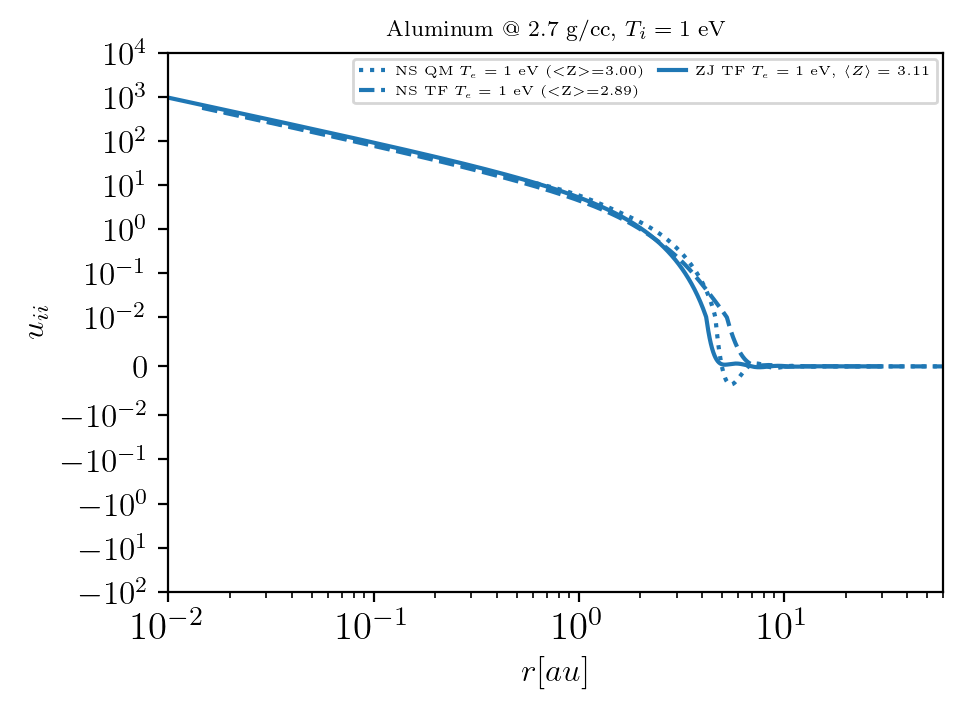

In [14]:
def plot_uii(uii_data, figax = None, **kwargs):#line = None, color=None, label=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax  = figax
    
    ax.plot(uii_data[0], uii_data[1], **kwargs )#, linestyle=line, color=color, label=label)
    
    ax.set_xlim(1e-2,60)
    ax.set_ylim(-1e2,1e4)
    ax.set_yscale('symlog', linthresh=1e-2)
    ax.set_xscale('log')
    
    ax.set_ylabel(r"$u_{ii}$")
    ax.set_xlabel(r"$r [au]$")
    
    ax.legend(fontsize=4.8, ncols=2, labelspacing=0.5, columnspacing=1)

def load_NS_u_data(filename, fix_factor=1):
    NS_aa = read_csv(filename, skiprows=8, delim_whitespace=True, names=["r", "uii","dvdr"])
    return NS_aa.r, NS_aa.uii*fix_factor
NS_folder = "/home/zach/plasma/average_atom/data/aluminum_2T/aluminum_2T_NS/"

# Fixed Ti cases
NS_tf_u11 = load_NS_u_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/tf_potential_for_md.jerome.dat")
NS_ks_u11 = load_NS_u_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/qm_potential_for_md.jerome.dat")

# Fixed Ti
fig, ax = plt.subplots()
ax.set_title(r"Aluminum @ $2.7$ g/cc, $T_i = 1 $ eV", fontsize=8)

plot_uii(NS_ks_u11, figax = (fig, ax), color=color_cycle[0], linestyle=':', label=r"NS QM $T_e=1$ eV (<Z>=3.00)")
plot_uii(NS_tf_u11, figax = (fig, ax), color=color_cycle[0], linestyle='--', label=r"NS TF $T_e=1$ eV (<Z>=2.89)")
plot_uii(np.array([aa_ZJ.iet.r_array*rs, aa_ZJ.uii_r_eff_iet]), figax = (fig, ax), color=color_cycle[0], linestyle='-',
         label=r"ZJ TF $T_e=1$ eV, $\langle Z \rangle ={0:0.2f}$".format(aa_ZJ.Zstar))
# plot_uii([NS_tf_u11[0], 2.89**2/NS_tf_u11[0]], figax = (fig, ax), color=color_cycle[0], linestyle='-', label=r"Coulomb (Z=2.89)")


In [6]:
from importlib import reload
try:
    reload(plotting)
except NameError as e:
    from average_atom.core import plotting as plotting
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)
    
from average_atom.core.plotting import compare_aa, plot_convergence, plot_Uei, plot_Uii, plot_hii

# fig, axs = plot_Uei([aa_CS, aa_ZJ, aa_ZJ_cs])
# fig, axs = plot_Uii([aa_CS, aa_ZJ, aa_ZJ_cs])
compare_aa([aa_W])
plot_convergence(aa_W)
aa_W.make_plots()



Error:  name 'plotting' is not defined


NameError: name 'aa_W' is not defined

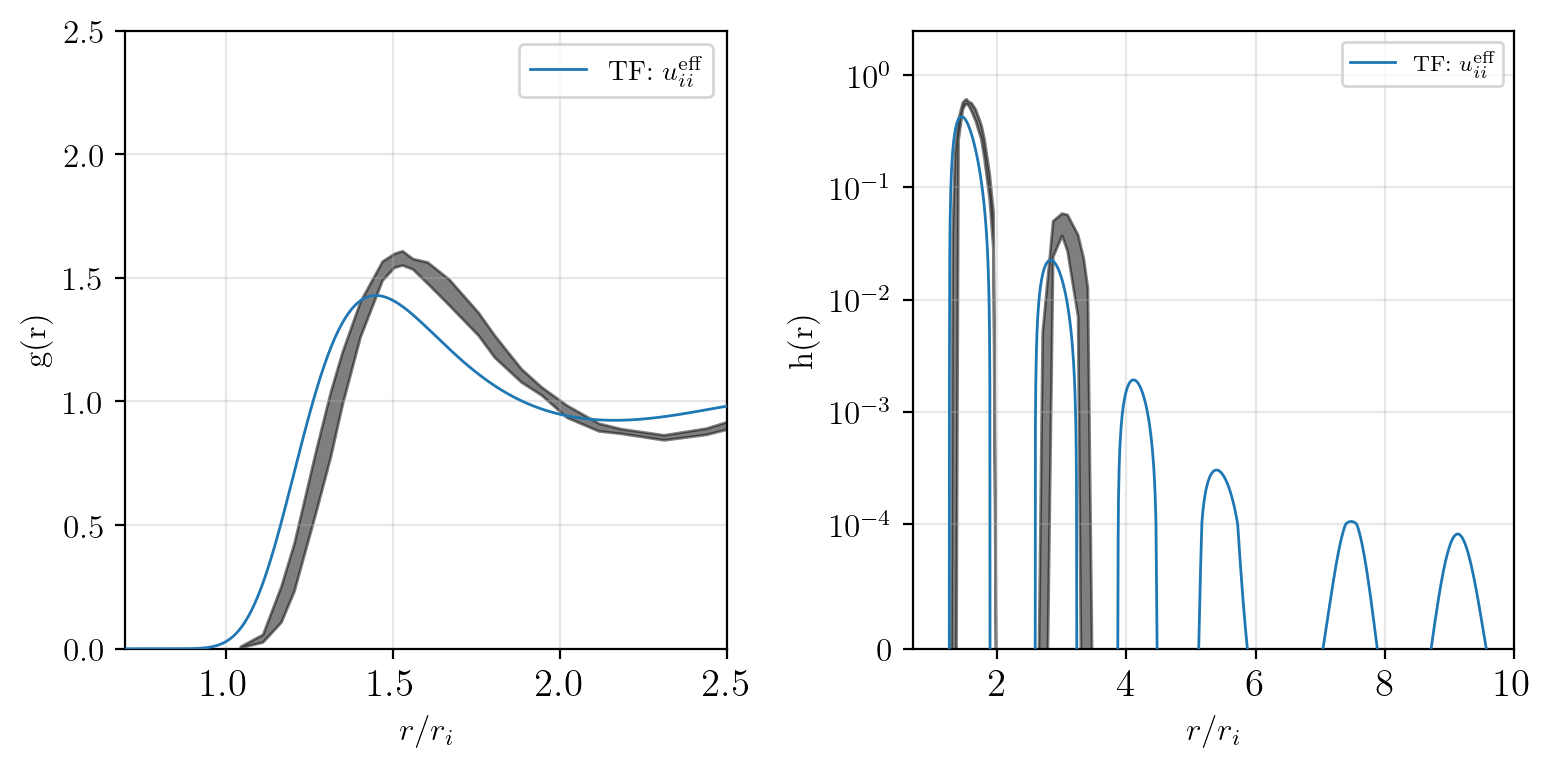

In [8]:
from scipy.interpolate import PchipInterpolator
from pandas import read_csv

fig, axs = plot_hii([aa_ZJ])

# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax = axs[0]
ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')

ax = axs[1]
ax.fill_between(lower_data['r/ri'],lower_data['gii']-1, PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri'])-1, alpha=0.5, color='k', label='Workshop DFT Spread')


### Compare Density Profiles

NameError: name 'NS_ks_ne11' is not defined

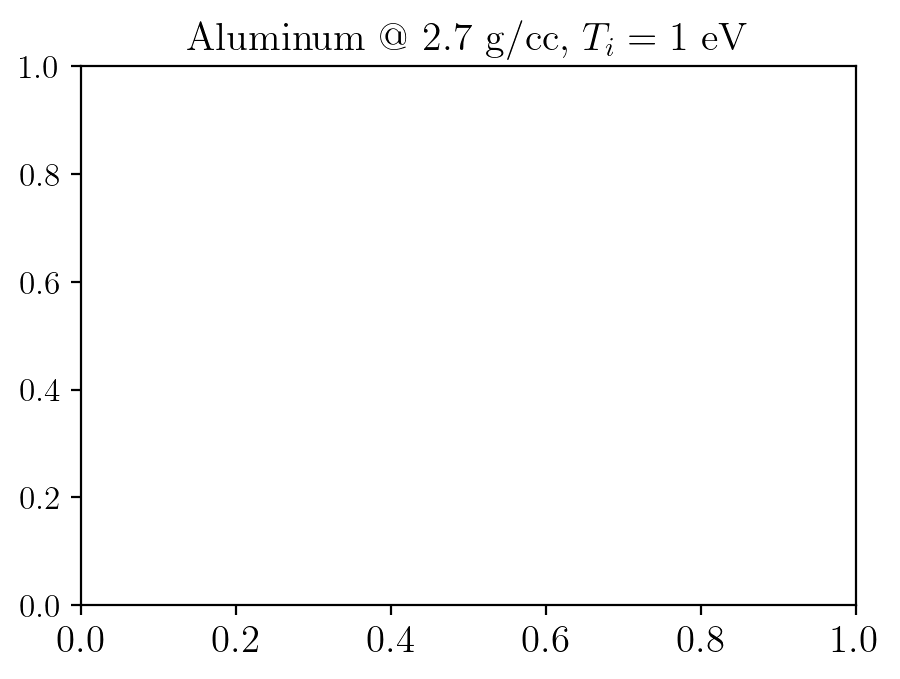

In [13]:
def plot_ne(ne_data, ks=False, figax = None, **kwargs):#line = None, color=None, label=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax  = figax
    
    fourpi = True
    if fourpi==True:
        if ks==False:
            ax.plot(ne_data[0], 4*π*ne_data[0]**2*ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        else:
            ax.plot(ne_data[0], ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        ax.set_ylabel(r"$4 \pi  r^2 n_{bound}$")        
    else:
        if ks==False:
            ax.plot(ne_data[0], ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        else:
            ax.plot(ne_data[0], (4*π*ne_data[0]**2)**-1*ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        ax.set_ylabel(r"$n_{free} $ [au]")        

    if True:
        ax.set_xlim(0,rs)
        ax.set_ylim(0, 13)
    else:
        ax.set_xlim(1e-2,30)
        ax.set_yscale('log')#, linthresh=1e-3)
        ax.set_xscale('log')
        ax.set_ylim(1e-3, 1e1)

    
    ax.set_xlabel(r"$r $ [au]")
    
    ax.legend(fontsize=6, ncols=2)
    
# Fixed Ti
fig, ax = plt.subplots()
ax.set_title(r"Aluminum @ $2.7$ g/cc, $T_i = 1 $ eV")

plot_ne(NS_ks_ne11, ks=True, figax = (fig, ax), color=color_cycle[0], linestyle='-', label=r"NS QM $T_e=1$ eV")
plot_ne(NS_tf_ne11, ks=False, figax = (fig, ax), color=color_cycle[0], linestyle='--', label=r"NS TF $T_e=1$ eV")
# ZJ_csaa = np.array([aa_CS.grid.xs, aa_CS.ne_full])
ZJ_tfaa = np.array([aa_ZJ.grid.xs, aa_ZJ.ne])
ZJ_tfaa_cs = np.array([aa_ZJ_cs.grid.xs, aa_ZJ_cs.ne])
plot_ne(ZJ_csaa, ks=False, figax = (fig, ax), color=color_cycle[1], linestyle='-', marker='', markersize=1, label=r"ZJ (SS2014) TF $T_e=1$ eV $\langle Z \rangle$={0:0.2f}".format(aa_CS.Zstar))
plot_ne(ZJ_tfaa, ks=False, figax = (fig, ax), color=color_cycle[2], linestyle='--', marker='', markersize=1, label=r"ZJ (IS) TF $T_e=1$ eV $\langle Z \rangle$={0:0.2f}".format(aa_ZJ.Zstar))
plot_ne(ZJ_tfaa_cs, ks=False, figax = (fig, ax), color=color_cycle[3], linestyle=':', marker='', markersize=1, label=r"ZJ (CS) TF $T_e=1$ eV $\langle Z \rangle$={0:0.2f}".format(aa_ZJ.Zstar))
# ZJ_csaa = np.array([aa_CS.core_atom.grid.xs, aa_CS.core_atom.ne])
# plot_ne(ZJ_csaa, ks=False, figax = (fig, ax), color=color_cycle[1], linestyle='--', marker='.', markersize=1, label=r"ZJ (CS2014) TF $T_e=1$ eV")

In [ ]:
from scipy.interpolate import interp1d

fig, ax  = plt.subplots()

ZJ_csaa = np.array([aa_CS.grid.xs, aa_CS.ne_full])

# ax.plot(aa_CS.core_atom.grid.xs, aa_CS.grid.A_dfdx.dot(aa_CS.core_atom.φe  ), '--.')
ax.plot(aa_CS.core_atom.grid.xs, aa_CS.core_atom.grid.A_dfdx.dot(aa_CS.core_atom.φe + aa_CS.core_atom.φion ), '--.')
ax.plot(aa_CS.core_atom.grid.xs, (aa_CS.core_atom.φe + aa_CS.core_atom.φion ), '--.')
ax.plot(ZJ_csaa[0], ZJ_csaa[1]/interp1d(NS_tf_ne11[0], NS_tf_ne11[1])(ZJ_csaa[0])-1, ':')

ax.set_yscale('symlog', linthresh=1e-8)
ax.set_xlim(np.min(ZJ_csaa[0]),3)
# ax.set_xscale('log')
ax.grid(alpha=0.2)

## EOS

In [ ]:
def get_E(aa):
    βVeff = aa.get_βVeff(aa.φe, aa.ne, aa.ne_bar)
    η = aa.μ/aa.Te - βVeff
    βU = aa.grid.integrate_f(βVeff*aa.ne)
    
    φ_from_e_only = aa.get_φe(-aa.ne)[0] 
    φ_from_i_only = aa.get_φe(aa.ρi)[0] + aa.φion 
    U = -aa.grid.integrate_f(aa.ne * (0.5*φ_from_e_only + φ_from_i_only))

    I_onehalf = FermiDirac.Ionehalf(η)
    I_threehalf = FermiDirac.Ithreehalf(η)
    
    K = (2*aa.Te)**1.5/(2*π**2) * aa.Te * aa.grid.integrate_f( I_threehalf)
    return U, K, (U + K)

def get_P(aa):
    P = (2*aa.Te)**2.5/(6*π**2) * FermiDirac.Ithreehalf(aa.μ/aa.Te)
    return P

def print_EOS(aa):
    Ee_pot, Ee_K, Ee = get_E(aa)
    P_e =  get_P(aa)
    print(f"____________________________________________")
    print(f"Ee_pot_density = {Ee_pot*aa.ni_bar:0.3e} [au], Ee_K = {Ee_K*aa.ni_bar:0.3e} [au], Ee_tot = {Ee*aa.ni_bar:0.3e} [au]")
    print(f"P_e = {P_e:0.3e} [au], {P_e*AU_to_bar/1e6:0.3e} [Mbar]")
    print(f"Virial if {Ee_K:0.3e} = {3/2*P_e*aa.Vol - 0.5*Ee_pot:0.3e} --->  off by {100*Ee_K/(3/2*P_e*aa.Vol - 0.5*Ee_pot) - 100:0.3e} % ")
    
    print(f"\nβEe_pot/Z = {Ee_pot/aa.Te/aa.Z:0.3f}, βEe_K/Z = {Ee_K/aa.Te/aa.Z:0.3f}, βEe_tot/Z = {Ee/aa.Te/aa.Z:0.3f}")
    print(f"βP_e Ω/Z = {P_e*aa.Vol/aa.Te/aa.Z:0.3f}")
    # print(f"Virial if {Ee_K:0.3e} = {3/2*P_e*aa.Vol - 0.5*Ee_pot:0.3e}")

print_EOS(aa_ZJ)
print_EOS(aa_ZJ_cs)
print_EOS(aa_CS.core_atom)